<a href="https://colab.research.google.com/github/CastroNicole/CastroN_FinalProject_IntroductionToWebDevelopment/blob/main/Special_Problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install Augmenter

In [6]:
pip install numpy

In [7]:
pip install keras

In [8]:
pip install pandas

In [9]:
pip install tensorflow

In [10]:
pip install matplotlib

In [11]:
pip install scikit-learn

In [1]:
from PIL import Image
import os

input_dir = "/content/drive/MyDrive/Special Problem/Leaves/Datasets/Diseases"

# Convert all images to RGB
for root, dirs, files in os.walk(input_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            with Image.open(file_path) as img:
                if img.mode != 'RGB':
                    rgb_img = img.convert('RGB')
                    rgb_img.save(file_path)
                    print(f"Converted {file_path} to RGB.")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

In [3]:
!pip install Augmentor

In [4]:
import Augmentor

In [12]:
p = Augmentor.Pipeline("/content/drive/MyDrive/Special Problem/Leaves/Datasets/Diseases", output_directory="/content/drive/MyDrive/Special Problem/Leaves/Outputs/output")

Initialised with 24500 image(s) found.
Output directory set to /content/drive/MyDrive/Special Problem/Leaves/Outputs/output.

In [13]:
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)

In [14]:
import pathlib
import tensorflow as tf

data_dir = pathlib.Path('/content/drive/MyDrive/Special Problem/Leaves/Datasets/Diseases')
img_height = 224
img_width = 224

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=8
)

Found 24500 files belonging to 6 classes.
Using 19600 files for training.


In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=8
)

Found 24500 files belonging to 6 classes.
Using 4900 files for validation.


In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [20]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [21]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
base_model1 = InceptionV3(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)
# Freeze the first 10 layers
for layer in base_model1.layers[:10]:
    layer.trainable = False

# Custom head
x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions1 = Dense(6, activation='softmax')(x)

# Final Model
model1 = Model(inputs=base_model1.input, outputs=predictions1)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
base_model2 = VGG16(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)
# Freeze the first 10 layers
for layer in base_model2.layers[:10]:
    layer.trainable = False

x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions2 = Dense(6, activation='softmax')(x)

model2 = Model(inputs=base_model2.input, outputs=predictions2)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Checkpoint to save best model per epoch

model_filepath = "/content/drive/MyDrive/Special Problem/Leaves/Models/model-{epoch:02d}-{val_accuracy:.4f}.keras"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [25]:
model1.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
model2.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
print("Model Input Shape:", model1.input_shape)
print("Dataset Sample Shape:", next(iter(train_ds))[0].shape)

Model Input Shape: (None, 224, 224, 3)
Dataset Sample Shape: (8, 224, 224, 3)


In [28]:
history1=model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,
  callbacks=[checkpoint]
)

Epoch 1/5
2448/2450 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4669 - loss: 1.3918
Epoch 1: val_accuracy improved from -inf to 0.67041, saving model to /content/drive/MyDrive/Special Problem/Leaves/Models/model-01-0.6704.keras
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 180s 39ms/step - accuracy: 0.4670 - loss: 1.3915 - val_accuracy: 0.6704 - val_loss: 0.8883
Epoch 2/5
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6459 - loss: 0.9542
Epoch 2: val_accuracy improved from 0.67041 to 0.67694, saving model to /content/drive/MyDrive/Special Problem/Leaves/Models/model-02-0.6769.keras
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 67s 27ms/step - accuracy: 0.6459 - loss: 0.9542 - val_accuracy: 0.6769 - val_loss: 0.8369
Epoch 3/5
2449/2450 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6919 - loss: 0.8392
Epoch 3: val_accuracy did not improve from 0.67694
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 67s 27ms/step - accuracy: 0.6919 - loss: 0.8392 - val_accuracy: 0.5714 - val_loss: 1.3791
Epoch 4/5
2450/2450 ━━━━━━━━━━

In [29]:
model1.save('model1.keras')

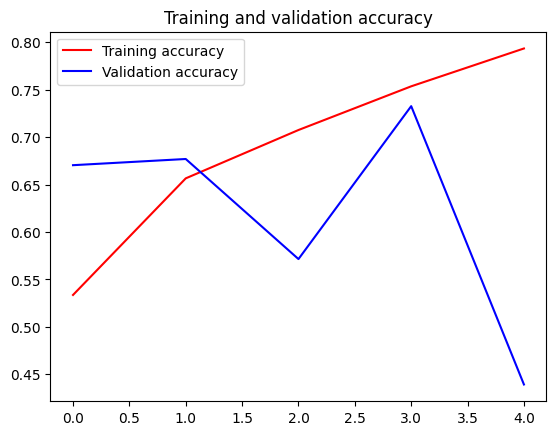

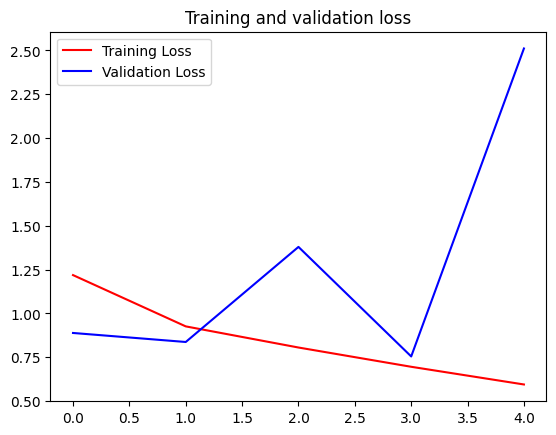

In [30]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
history2=model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15,
  callbacks=[checkpoint]
)

Epoch 1/15
2445/2450 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1999 - loss: 1.7702
Epoch 1: val_accuracy did not improve from 0.73265
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.1999 - loss: 1.7702 - val_accuracy: 0.1984 - val_loss: 1.7724
Epoch 2/15
2446/2450 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2077 - loss: 1.7694
Epoch 2: val_accuracy did not improve from 0.73265
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.2077 - loss: 1.7694 - val_accuracy: 0.1984 - val_loss: 1.7721
Epoch 3/15
2449/2450 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1963 - loss: 1.7710
Epoch 3: val_accuracy did not improve from 0.73265
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.1963 - loss: 1.7710 - val_accuracy: 0.1984 - val_loss: 1.7732
Epoch 4/15
2449/2450 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2065 - loss: 1.7701
Epoch 4: val_accuracy did not improve from 0.73265
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.2065 - loss: 1.7701 - 

In [33]:
model2.save('model2.keras')

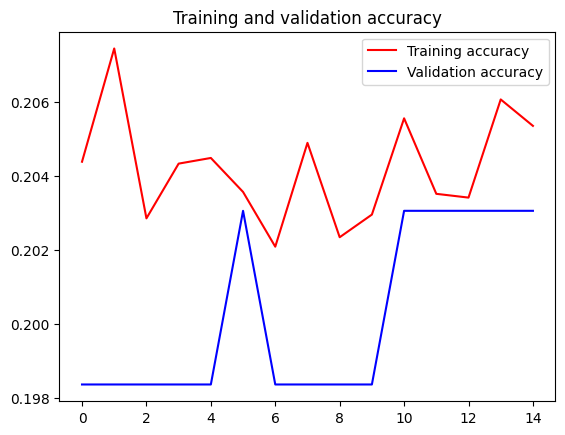

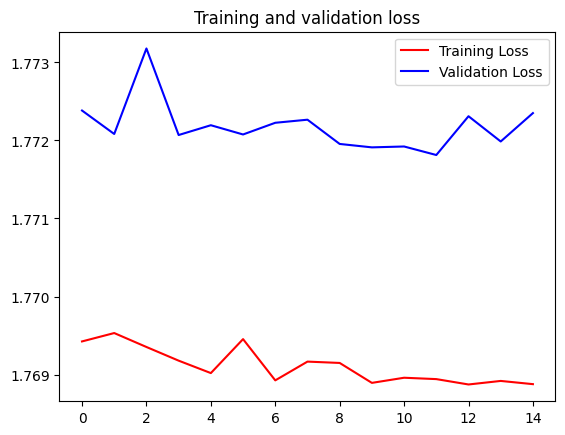

In [34]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Average, Input, Lambda
import tensorflow as tf

# Load models
model_1 = load_model('/content/drive/MyDrive/Special Problem/Leaves/Models/model-02-0.6769.keras')
model_2 = load_model('/content/drive/MyDrive/Special Problem/Leaves/Models/model-04-0.7327.keras')

# Input layer
model_input = Input(shape=(224, 224, 3))

# Wrap each model in Lambda layers to isolate their computational graphs
output_1 = Lambda(lambda x: model_1(x), name="model_1_output")(model_input)
output_2 = Lambda(lambda x: model_2(x), name="model_2_output")(model_input)

# Merge outputs using Average
ensemble_output = Average(name="ensemble_average")([output_1, output_2])

# Create ensemble model
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

# Compile ensemble model
ensemble_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Ensemble model created successfully.")


Ensemble model created successfully.


In [41]:
ensemble_model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [42]:
history=ensemble_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[checkpoint]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


2448/2450 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7624 - loss: 0.6866
Epoch 1: val_accuracy improved from 0.73265 to 0.78898, saving model to /content/drive/MyDrive/Special Problem/Leaves/Models/model-01-0.7890.keras
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 89s 25ms/step - accuracy: 0.7624 - loss: 0.6866 - val_accuracy: 0.7890 - val_loss: 0.5978
Epoch 2/10
2448/2450 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7619 - loss: 0.6778
Epoch 2: val_accuracy improved from 0.78898 to 0.78918, saving model to /content/drive/MyDrive/Special Problem/Leaves/Models/model-02-0.7892.keras
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.7619 - loss: 0.6778 - val_accuracy: 0.7892 - val_loss: 0.5893
Epoch 3/10
2449/2450 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7612 - loss: 0.6896
Epoch 3: val_accuracy improved from 0.78918 to 0.79102, saving model to /content/drive/MyDrive/Special Problem/Leaves/Models/model-03-0.7910.keras
2450/2450 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.76

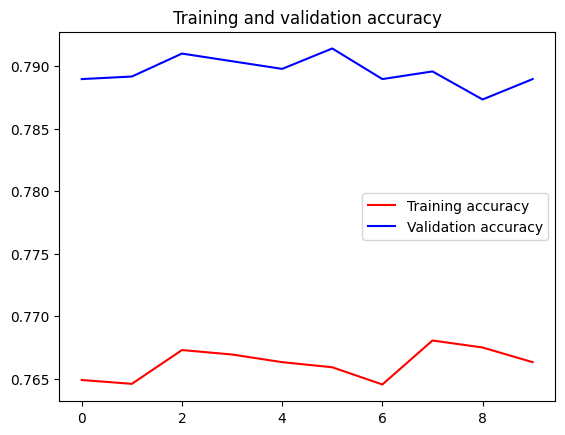

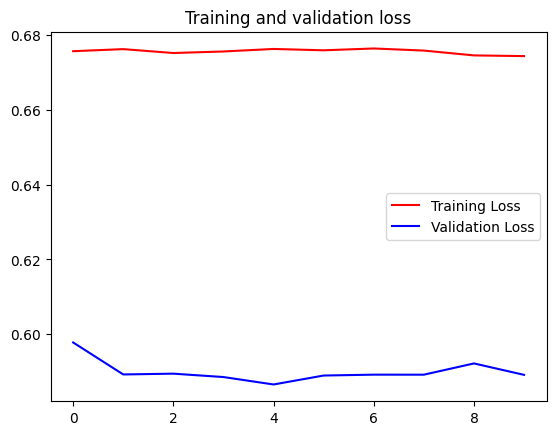

In [43]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
train_label = np.concatenate([y for x, y in train_ds], axis = 0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis = 0)
print(test_label.shape)

(19600,)
(4900,)


613/613 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step
Confusion Matrix
[[795 130   6  20  18   3]
 [ 45 860   0  42   8  40]
 [ 22  44 668  31   1   9]
 [  0 111   0 576  50  86]
 [ 43 127   0  93 215  33]
 [  2  34   0  36   0 752]]


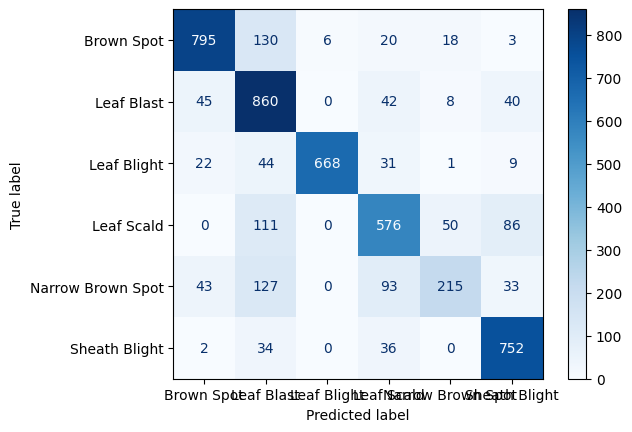

Classification Report
                   precision    recall  f1-score   support

       Brown Spot       0.88      0.82      0.85       972
       Leaf Blast       0.66      0.86      0.75       995
      Leaf Blight       0.99      0.86      0.92       775
       Leaf Scald       0.72      0.70      0.71       823
Narrow Brown Spot       0.74      0.42      0.54       511
    Sheath Blight       0.81      0.91      0.86       824

         accuracy                           0.79      4900
        macro avg       0.80      0.76      0.77      4900
     weighted avg       0.80      0.79      0.79      4900



In [45]:
# Predict on the validation dataset
Y_pred = ensemble_model.predict(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(test_label, y_pred)
print('Confusion Matrix')
print(cm)

# Display the confusion matrix as a heatmap
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Brown Spot', 'Leaf Blast', 'Leaf Blight', 'Leaf Scald', 'Narrow Brown Spot', 'Sheath Blight'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print('Classification Report')
target_names = ['Brown Spot', 'Leaf Blast', 'Leaf Blight', 'Leaf Scald', 'Narrow Brown Spot', 'Sheath Blight']
print(classification_report(test_label, y_pred, target_names=target_names))

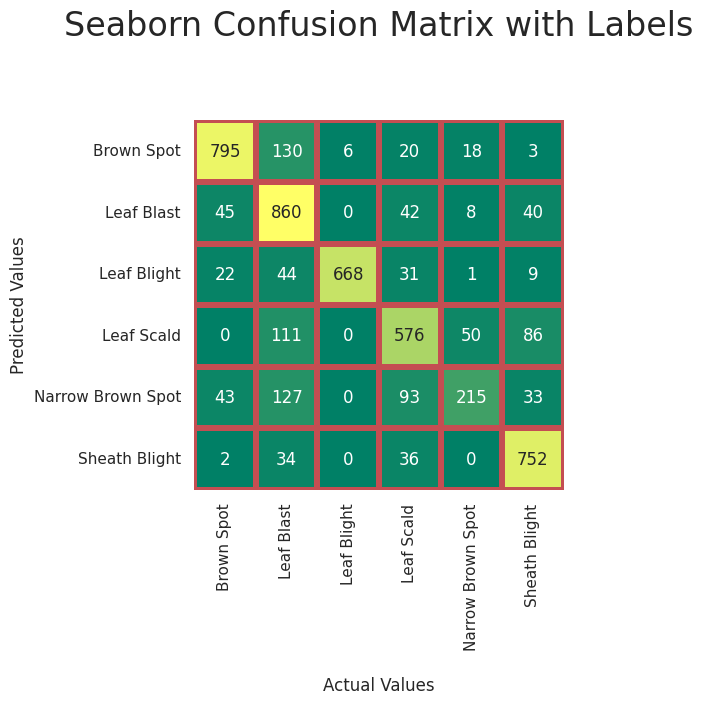

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define target names
target_names = ['Brown Spot', 'Leaf Blast', 'Leaf Blight', 'Leaf Scald', 'Narrow Brown Spot', 'Sheath Blight']

# Plot confusion matrix using seaborn
sns.set(font_scale=1.0)
ax = sns.heatmap(cm, annot=True, cmap='summer', cbar=False, linewidths=3,
                 linecolor='r', square=True, xticklabels=target_names,
                 yticklabels=target_names, fmt='d')
sns.set(font_scale=2.0)
ax.set_title('Seaborn Confusion Matrix with Labels\n\n')
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values')

plt.show()